In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from obspy.taup import TauPyModel
import function_repo as fr
from collections import defaultdict
import importlib
np.random.seed(1029)

In [ ]:
"""
THIS IS WHERE IT'S AT
Look at Suzan's notes
Make my own notes
Systematize the process
Comment this code
"""

"""
Use smaller ellipsoids for more definitive visualizations
Plot the vectors of amplitudes

There's something about the shape of the ellipsoid...
Test my_tp2sdr rigorously against tp2sdr

Forward problem: scan through entire space
Plot same mechanism over
az = [0,360] from compass north
takeoff = [0,180] from south pole
Turn distance into takeoff angles, scan distances
Revise the beachball code to accurately represent the beachball
"""

In [ ]:
"""
CODE FLOW:

1. Normal fault, plot and save amplitude space
    - plot beachball(?)
    
2. Get more realistic amp space from distances

3. Do an inverse method on the whole amp space, small noise
    - target? how do we measure other than visual inspection?
    - which visuals? 3D amp, correlations, etc.
    - how to track changes in ellipsoid size?
3. (for real) The simplest possible inverse method
    - optimize the search algorithm later
"""

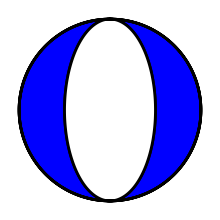

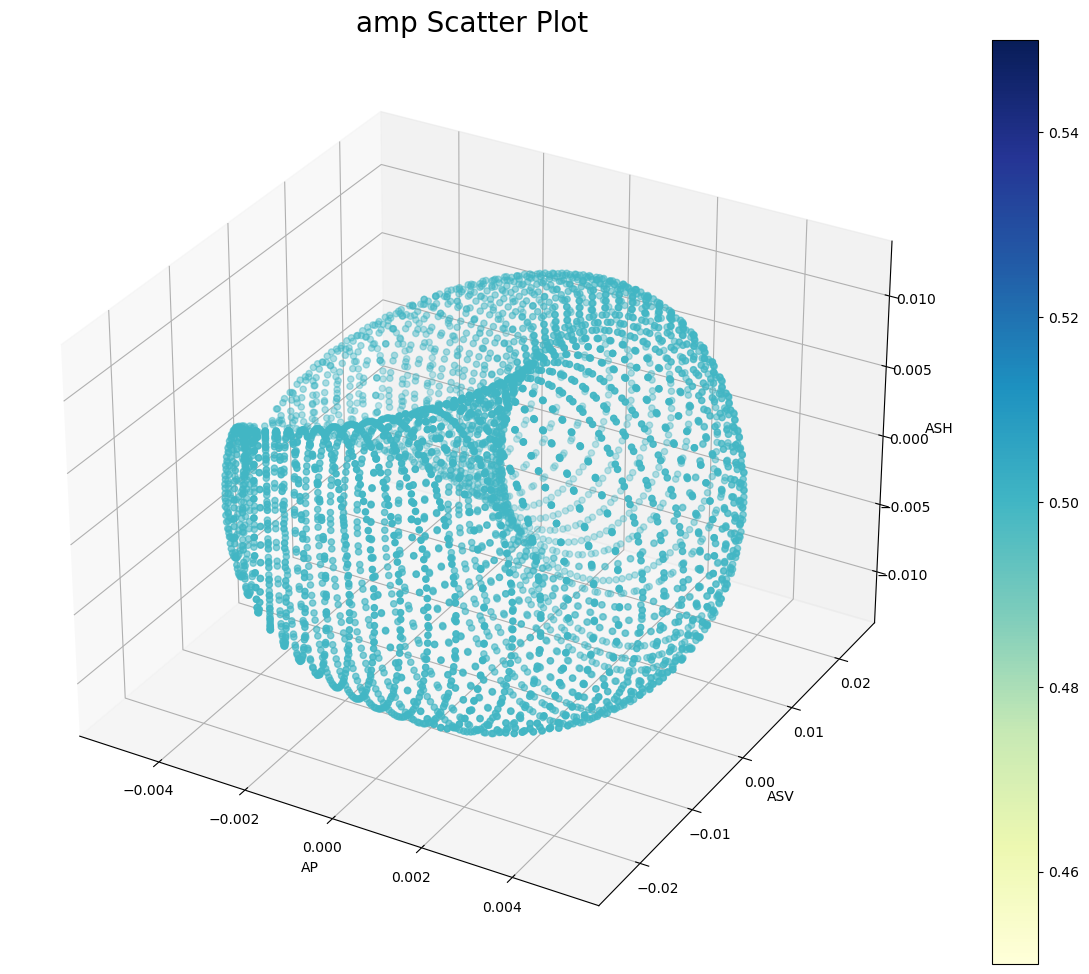

In [115]:
# (Normal) fault, plot and save amplitude space
# for every azimuth-takeoff angle pair, plot the amplitudes
# fixed mechanism, variable measurement parameters

importlib.reload(fr)
dd = 3 # step size in degrees, subject to change
# azimuths = np.arange(0, 360, dd)
takeoff_angles = np.arange(0, 180, dd)
alpha_beta = [5.8000, 3.4600] # from Suzan's notes

# fault orientations
t, p = fr.i_hat, fr.k_hat # subject to change
# tested my_tp2sdr against tp2sdr, it works properly now
sdr = fr.my_tp2sdr(t, p, True)[0]

# plot corresponding beachball
fr.beachball(sdr1)

# generate amplitude space
# assumes same takeoff angles for P and S waves
# typically should come from velocity model
amps = defaultdict(list)

# applying logic of spherical distribution
for takeoff in takeoff_angles:
    if takeoff == 0: azimuths = np.array([0])
    else: azimuths = np.arange(0, 360, dd/abs(np.sin(np.deg2rad(takeoff))))
    for az in azimuths:
        As = fr.Rpattern(sdr, az, [takeoff, takeoff], alpha_beta)
        amps["AP"].append(As[0])
        amps["ASV"].append(As[1])
        amps["ASH"].append(As[2])
        amps["Standard"].append(0.5)

# plot and save amplitude space
fr.weighted_3D_scatter(amps, "Standard", type="amp", save="amp_space.png")
# got lucky not to need a dataframe

24/100 rejected epicentral distances
[0, 1, 2, 3, 4] [24, 25, 26, 27, 28]


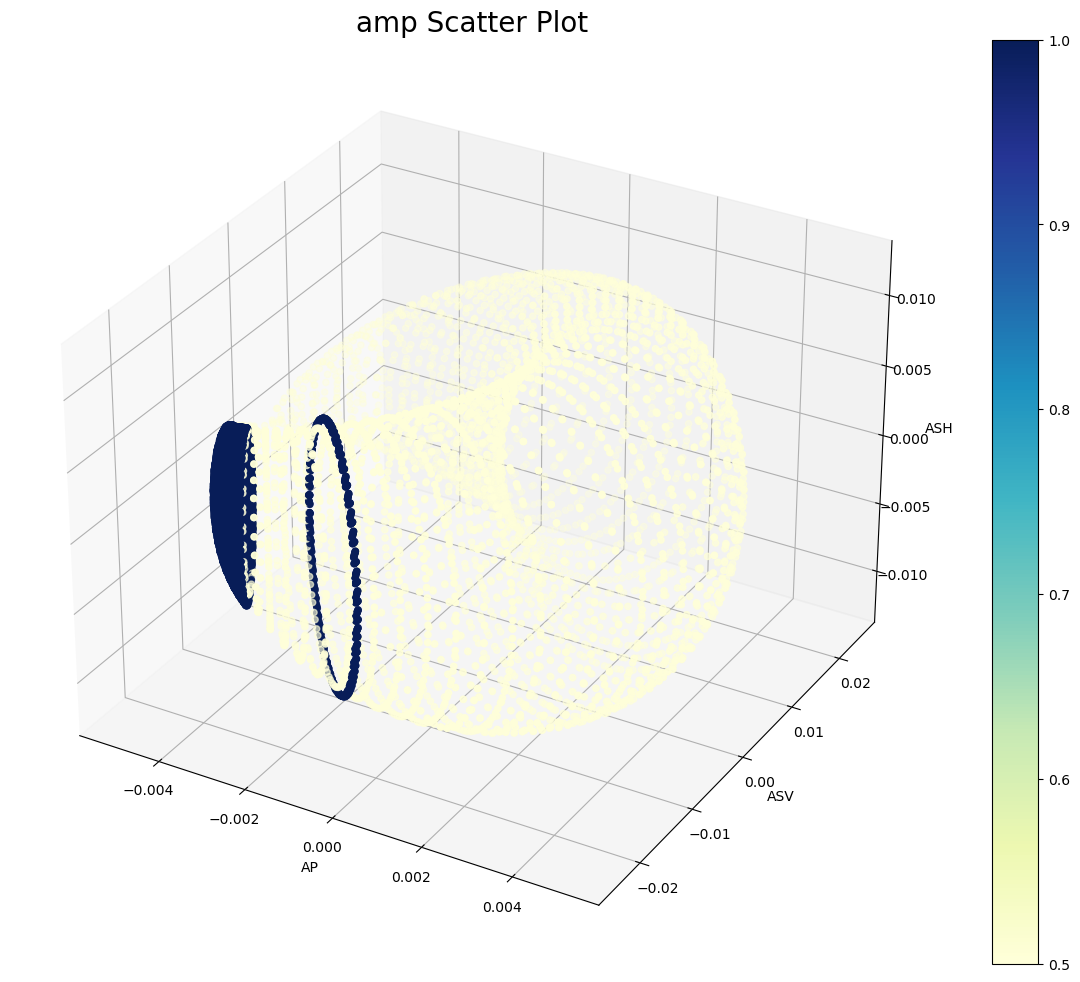

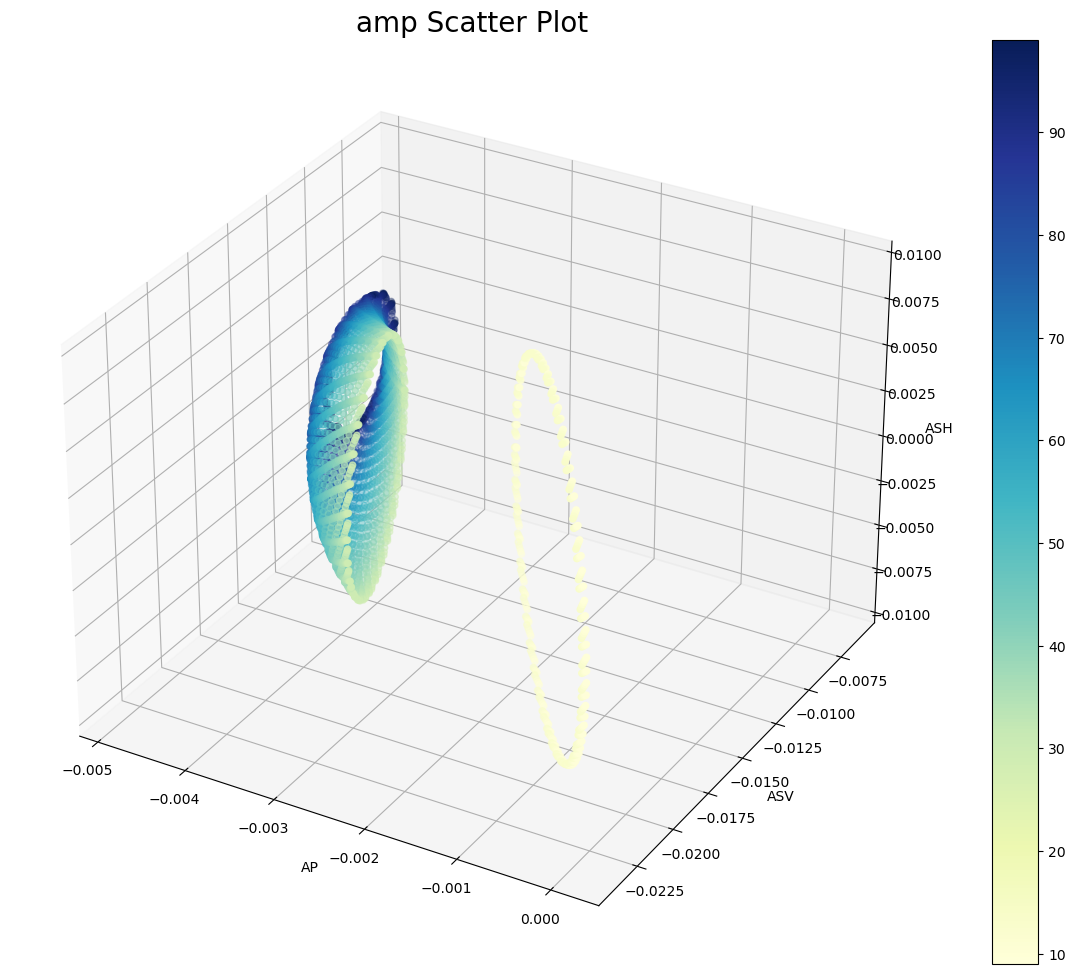

'See also real_amps_with_grad.png'

In [46]:
# Realistic amplitude space, using velocity model

model = TauPyModel(model='ak135') # velocity model
hdepth = 15 # km - assumed quake depth, subject to change
epdists = [i for i in range(100)] # km - epicentral distance
# same azimuths

realistic_takeoff_angles = []
rejected_epdists = []
for epdist in epdists:
    arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                         distance_in_degree=epdist, phase_list=['P', 'S'])
    angles = [a.takeoff_angle for a in arrivals]
    if len(angles) == 2:
        realistic_takeoff_angles.append(([a.takeoff_angle for a in arrivals], epdist))
    else:
        rejected_epdists.append(epdist)

print(f"{len(rejected_epdists)}/{len(epdists)} rejected epicentral distances")
print(rejected_epdists[:5], rejected_epdists[-5:])
        
# plot realistic amplitude space over original
# assumption that P and S waves have same takeoff angles no longer holds
# same amps dictionary
# extra one to isolate realistic amps
real_amps = defaultdict(list)

for takeoff in realistic_takeoff_angles:
    average_takeoff = np.mean(takeoff[0])
    azimuths = np.arange(0, 360, dd/abs(np.sin(np.deg2rad(average_takeoff))))
    for az in azimuths:
        As = fr.Rpattern(sdr1, az, takeoff[0], alpha_beta)
        amps["AP"].append(As[0])
        amps["ASV"].append(As[1])
        amps["ASH"].append(As[2])
        amps["Standard"].append(1) # or takeoff[1] for distance gradient
        real_amps["AP"].append(As[0])
        real_amps["ASV"].append(As[1])
        real_amps["ASH"].append(As[2])
        real_amps["Standard"].append(takeoff[1])
        
# Plot and save amplitude space
fr.weighted_3D_scatter(amps, "Standard", type="amp", save="real_amp_space.png")
fr.weighted_3D_scatter(real_amps, "Standard", type="amp", save="real_amps.png")

"See also real_amps_with_grad.png"
# Do the plots myself, they're too variable to automate

In [63]:
# Simplest possible inverse method

# We don't know what mechanism it is, but we know that we have a set of amplitudes
# So I guess we need a forward problem from sdr space for a fixed az and takeoff
# How would this amplitude space look in comparison? Moving the station vs moving the ball


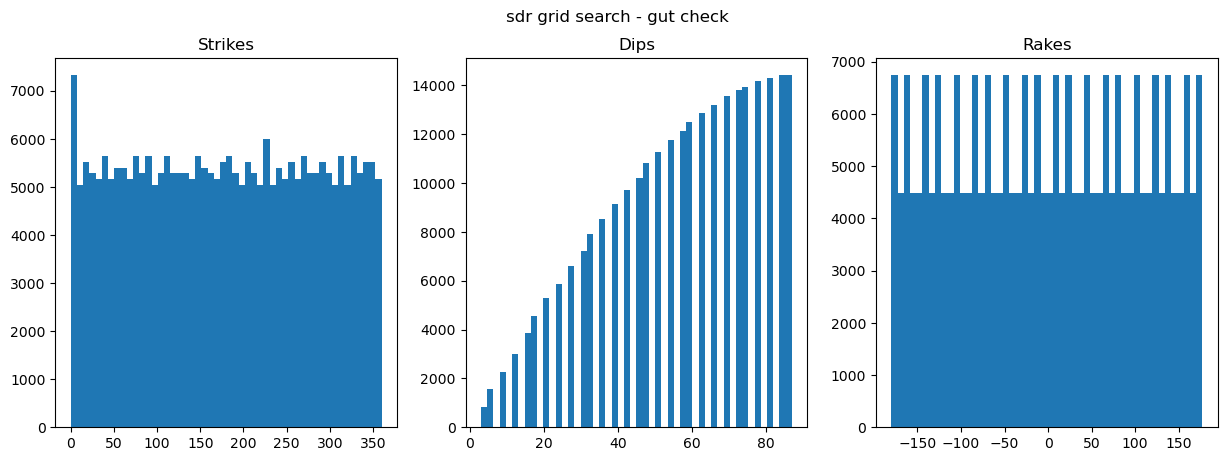

In [161]:
# sdr grid search

# Remember to account for sinusoidal distribution of dips - inverse transform sampling
# This may solve my geometry problem from tp -> sdr conversion

d_dip = 3 # step size in degrees, subject to change
dips = np.arange(0, 90, d_dip) # uniform samples from distribution of interest
sdrs = []

for dip in dips[1:]: # 0 dip makes no sense
    d_adj = d_dip/np.sin(np.deg2rad(dip))
    strikes = np.arange(0, 360, d_adj) # strikes restricted by dip
    rakes = np.arange(-180, 180, d_dip) # rakes dependent on sd pair
    for strike in strikes:
        for rake in rakes:
            sdrs.append(np.array([strike, dip, rake]))

# save sdrs
np.save("sdrs.npy", sdrs)
            
# Plot relevant histograms
s = [sdrs[i][0] for i in range(len(sdrs))]
d = [sdrs[i][1] for i in range(len(sdrs))]
r = [sdrs[i][2] for i in range(len(sdrs))]

fig, axs = plt.subplots(1, 3)
fig.suptitle("sdr grid search - gut check")
fig.set_figwidth(15)
nbins = 50
axs[0].hist(s, bins=nbins)
axs[0].set_title("Strikes")
axs[1].hist(d, bins=nbins)
axs[1].set_title("Dips")
axs[2].hist(r, bins=nbins)
axs[2].set_title("Rakes")
plt.show()

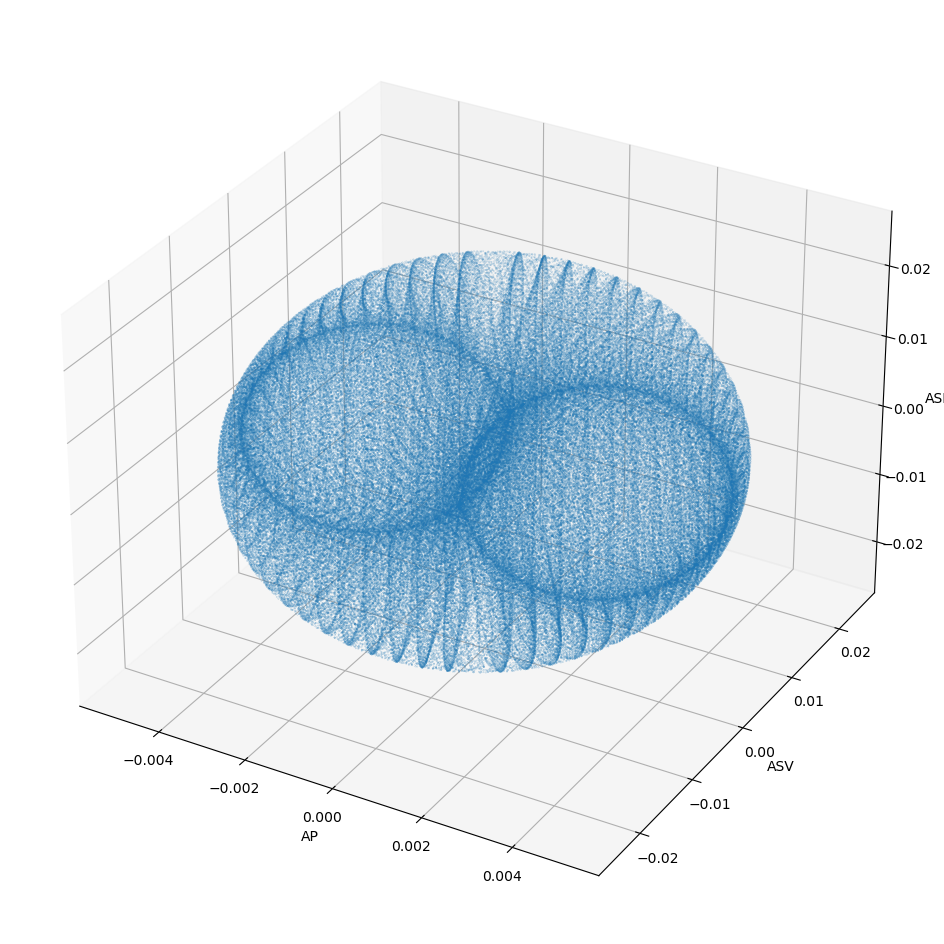

'Conclusion'

In [159]:
# Forward problem from sdr space for a fixed az and takeoff

az = 0
model = TauPyModel(model='ak135')
hdepth = 15
epdist = 45
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                         distance_in_degree=epdist, phase_list=['P', 'S'])
angles = [a.takeoff_angle for a in arrivals]
sdr_amps = defaultdict(list)

for sdr in sdrs:
    As = fr.Rpattern(sdr, az, angles, alpha_beta)
    sdr_amps["AP"].append(As[0])
    sdr_amps["ASV"].append(As[1])
    sdr_amps["ASH"].append(As[2])
    sdr_amps["Standard"].append(1)
    
# Plot and save amplitude space
# fr.weighted_3D_scatter(sdr_amps, "Standard", type="amp", save="sdr_amp_space.png")
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(sdr_amps["AP"], sdr_amps["ASV"], sdr_amps["ASH"], s=1/50)
ax.set_xlabel('AP')
ax.set_ylabel('ASV')
ax.set_zlabel('ASH')
plt.show()

"Conclusion" # I need random sampling (inverse transform sampling)
# To see if the patterns in the middle are real or just a result of the grid search
# I hope it's the latter, because there's no reason (yet) for the middle to be special

In [140]:
# Inverse problem given an observation in the realistic amplitude space
importlib.reload(fr)

az = 100
t, p = fr.i_hat, fr.k_hat # subject to change, match block 1
sdr = fr.my_tp2sdr(t, p, True)[0] # fixed mechanism
# fr.beachball(sdr)

Ao = fr.Rpattern(sdr, az, angles, alpha_beta)
sigS = 0.2 # subject to change
Uo = Ao*sigS
Uo[0] /= 2 # subject to change

"What did I pick from the realistic amplitude space?"

data = fr.sdr_inverse_method("sdrs.npy", az, angles, Ao, Uo, no_rejected=True)
print(f"Size of data: {len(data)}")
data.head()

Size of data: 115


,Strike,Dip,Rake,AP,ASV,ASH,OldWeight,Weight
0,147.793764,40.0,-110.0,-0.003591,-0.016290,-0.000819,0.003570,0.139976
1,155.572383,40.0,-105.0,-0.003803,-0.015946,-0.000833,0.011987,0.202681
2,163.351002,40.0,-100.0,-0.003964,-0.015649,-0.001061,0.034202,0.318061
3,171.129621,40.0,-95.0,-0.004068,-0.015448,-0.001455,0.062104,0.146712
4,194.465478,40.0,-85.0,-0.004066,-0.015724,-0.001105,0.046101,0.346484


In [141]:
# Working with the data, simplest possible inverse method

max_old_weight = max(data["OldWeight"])
max_weight = max(data["Weight"])

old_sdr_fit = data[data["OldWeight"] == max_old_weight]
sdr_fit = data[data["Weight"] == max_weight]
print(old_sdr_fit)
print(sdr_fit)

"Conclusion": # new inverse method works for the simplest possible case

   Strike   Dip  Rake        AP       ASV       ASH  OldWeight  Weight
6     0.0  45.0 -90.0 -0.004575 -0.012058 -0.001085        1.0     1.0
   Strike   Dip  Rake        AP       ASV       ASH  OldWeight  Weight
6     0.0  45.0 -90.0 -0.004575 -0.012058 -0.001085        1.0     1.0


In [ ]:
# I might want to experiment with the underlying algorithm for inverse method
# Look at global vs optimized search algorithms
# Recursively refine the search space
# Newton's method?
# Genetic algorithm?

"""
2 MAIN GOALS:
Accuracy and efficiency (both relative)
Accuracy: how close to the true mechanism is the estimated mechanism?
Efficiency: how many sdrs do I have to test to get a good estimate?

A big question is how to measure accuracy (statistically)

With these two, we can analyze variable dependencies

What's my research hypothesis?
"""

# Lord have mercy on my soul

In [ ]:
# Refining the search space
# How does this apply to the big picture?
# It's part of capabilities/limitations analysis
# It looks at the model's ability to work with more efficient implementation algorithms

"""
Insert algorithm here
"""

In [ ]:
# Generate aggregate beachballs in a way that reflects distribution
# How do I know the distribution, and whether or not it's reflected?
# Line graphs: strike vs weight, dip vs weight, rake vs weight